In [1]:
import sys
sys.path.append("..")

from src import uilc
import numpy as np
import math
import matplotlib.pyplot as plt


# Examples 

## Linear Array

system setting

In [2]:
s = 1.11
W = 0.2
H = 0.05
nnls_sigma= W/(8*1.3)
# Plot value
xline = np.linspace(-W/2, W/2 , 400)
yline = np.linspace(-W/2, W/2 , 400)
X, Y = np.meshgrid(xline, yline)

## ESC method

Using expanded Sparrow's Criterion

In [3]:
esc_n = uilc.esc.get_nmax(s, W, H)
esc_d = uilc.esc.coefficient(s ,esc_n) * H
esc_arr = uilc.utils.uniformarray(esc_d, esc_n) 
esc_arr_s = uilc.utils.get_2d_array(esc_arr, esc_arr, dim=2)

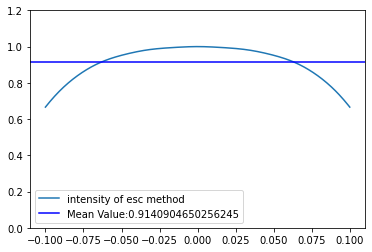

In [4]:
esc_intensity = uilc.utils.lambertian_distribution(xline, np.array([[[0]]]), esc_arr, s, H)
esc_y = esc_intensity[0][0]
esc_y = esc_y/esc_y.max()
plt.plot(xline, esc_y, label="intensity of esc method")
plt.axhline(y=esc_y.mean(), color='b', label="Mean Value:{}".format(esc_y.mean()))
plt.ylim(0, 1.2)
plt.legend()
plt.show()

(0.0, 4439.679402687039)

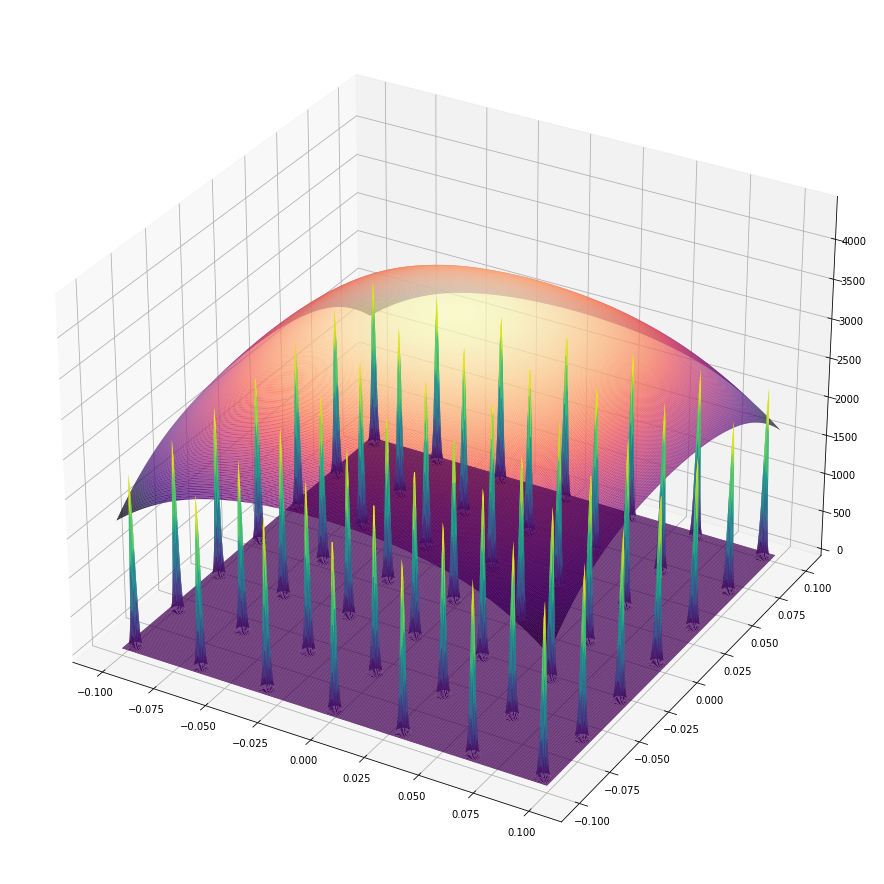

In [36]:
# 3D plot for square arrary
esc_Z = uilc.utils.lambertian_distribution(X, Y, esc_arr_s, s, H)
sigma = 0.0001
esc_led_distribution = uilc.utils.gauss_distribution(X,Y, esc_arr_s, nnls_sigma/10)
esc_led_distribution = esc_led_distribution *(esc_Z.max()/esc_led_distribution.max()) * 0.6

fig= plt.figure(figsize=(16,16))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, esc_Z, rstride= 1, cstride =1, cmap='magma', edgecolor='none')

ax.plot_surface(X,Y, esc_led_distribution, rstride = 1, cstride =1, cmap='viridis', edgecolor='none')
ax.set_zlim(0, esc_Z.max()*1.2)

In [37]:
fig.savefig('ESCmethod.png', transparent=True)

## BC-expansion method

This method optimize array with matching boundary-center intensity contribution of each LEDs given system.

In [29]:
bc_xe = uilc.disop.find_xe(W, H, s)
bc_xm = uilc.disop.find_xm(W, H, s, bc_xe)
bc_esc_n = uilc.disop.get_n_esc_max(s, H, bc_xm, bc_xe)
bc_esc_d = uilc.esc.coefficient(s, bc_esc_n) * H
bc_esc_arr = uilc.utils.uniformarray(bc_esc_d, bc_esc_n, 1)
bc_arr = uilc.disop.get_bc_expansion(bc_esc_arr, s, H, W, bc_xe, bc_xm)
bc_arr_s = uilc.utils.get_2d_array(bc_arr, bc_arr, dim=2)

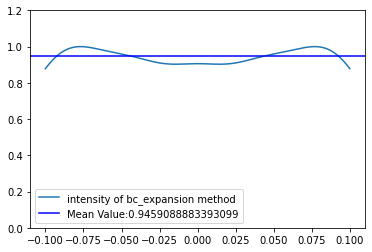

In [30]:
# Intensity graph
bc_xline = np.linspace(-W/2, W/2 , 400)
bc_intensity = uilc.utils.lambertian_distribution(bc_xline, np.array([[[0]]]), bc_arr, s, H)
bc_y = bc_intensity[0][0]
bc_y = bc_y/bc_y.max()
plt.plot(bc_xline, bc_y, label="intensity of bc_expansion method")
plt.axhline(y=bc_y.mean(), color='b', label="Mean Value:{}".format(bc_y.mean()))
plt.ylim(0, 1.2)
plt.legend()
plt.show()

(0.0, 3403.7236504593143)

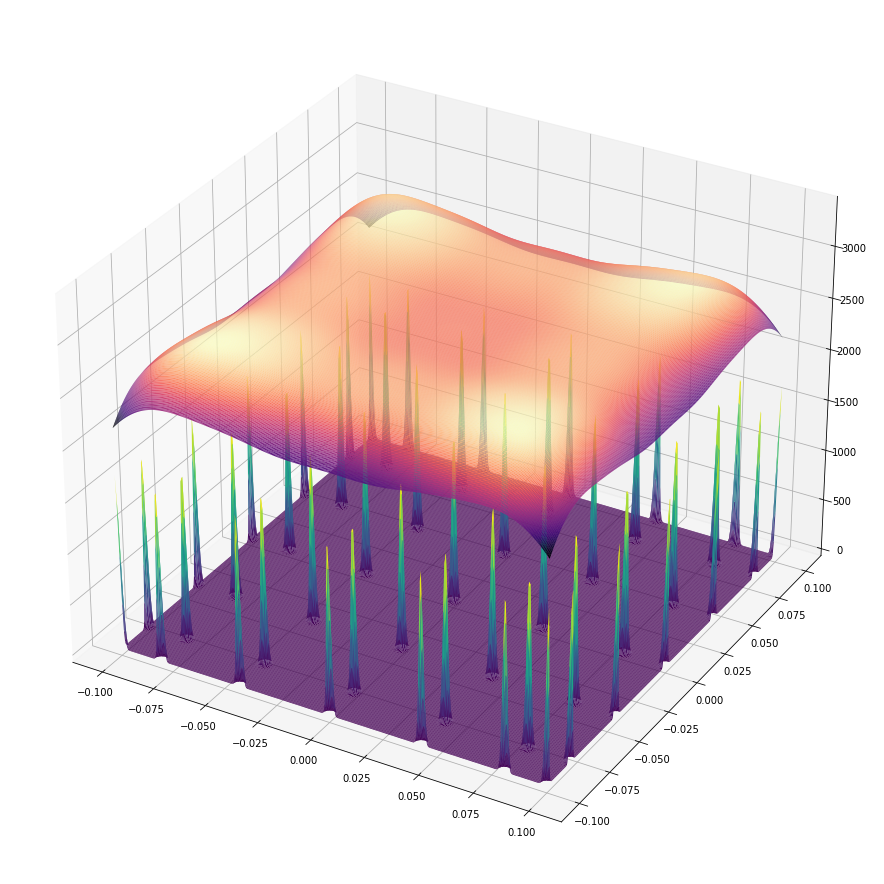

In [38]:
# 3D plot for square arrary
bc_Z = uilc.utils.lambertian_distribution(X, Y, bc_arr_s, s, H)

bc_led_distribution = uilc.utils.gauss_distribution(X,Y, bc_arr_s, nnls_sigma/10)
bc_led_distribution = bc_led_distribution *(bc_Z.max()/bc_led_distribution.max()) * 0.6

fig= plt.figure(figsize=(16,16))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, bc_Z, rstride= 1, cstride =1, cmap='magma', edgecolor='none')
ax.plot_surface(X,Y, bc_led_distribution, rstride = 1, cstride =1, cmap='viridis', edgecolor='none')
ax.set_zlim(0, bc_Z.max()*1.2)

In [39]:
fig.savefig('BCmethod.png', transparent=True)

## Discretize solve of integral equation

$n_{app} =$ Number of LEDs in bc expansion method

It is an approximation number. Maybe $n_{app}\pm 1$ would be more apropriate but mostly it is well fitted.

In [7]:
napp = bc_arr.shape[1]

### Direct solve

In [8]:
ds_rho, ds_position, ds_F = uilc.disop.solve_system(s, W, H)
# Normalization
ds_lamb = napp * ds_rho.size / (W*ds_rho.sum())
ds_rho = ds_lamb * ds_rho

$$\delta(x-a) \approx \frac{1}{\sigma \sqrt{2\pi}} \exp(- \frac{(x-a)^2}{2 \sigma^2})$$


$$\sigma = \frac{W}{2 n k}$$

$k$ is a coefficient.



In [9]:
ds_k = math.sqrt(2)*0.9
ds_sigma = W/(2*napp * ds_k)

In [10]:

ds_arr = uilc.disop.nomarlization_lq(bc_arr,  ds_position, ds_rho, napp, ds_sigma , W)
ds_arr_s = uilc.utils.get_2d_array(ds_arr, ds_arr, dim=2)

LED location and $\vec{\rho}$ compare

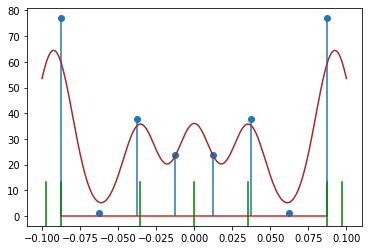

In [11]:
ds_pos_xline = np.linspace(-W/2, W/2, 400)
ds_pos_y = uilc.utils.gauss_distribution(ds_pos_xline, np.array([[[0]]]), ds_arr, ds_sigma )

plt.stem(ds_position, ds_rho)
plt.plot(ds_pos_xline, ds_pos_y[0][0], color="brown")
for x in ds_arr[0,0:napp][0:napp,0]:
    plt.axvline(x, ymin=0, ymax=0.2 , color="green")    
plt.show()

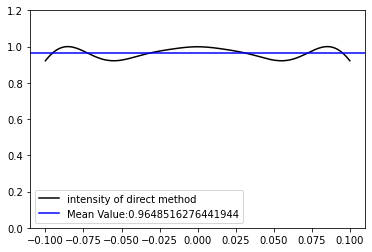

In [33]:
ds_xline = np.linspace(-W/2, W/2 , 400)
ds_intensity = uilc.utils.lambertian_distribution(ds_xline, np.array([[[0]]]), ds_arr, s, H)
ds_y = ds_intensity[0][0]
ds_y = ds_y/ds_y.max()
plt.plot(ds_xline, ds_y, label="intensity of direct method", color="black")
plt.axhline(y=ds_y.mean(), color='b', label="Mean Value:{}".format(ds_y.mean()))
plt.ylim(0, 1.2)
plt.legend()
plt.show()

(0.0, 3491.9725823149583)

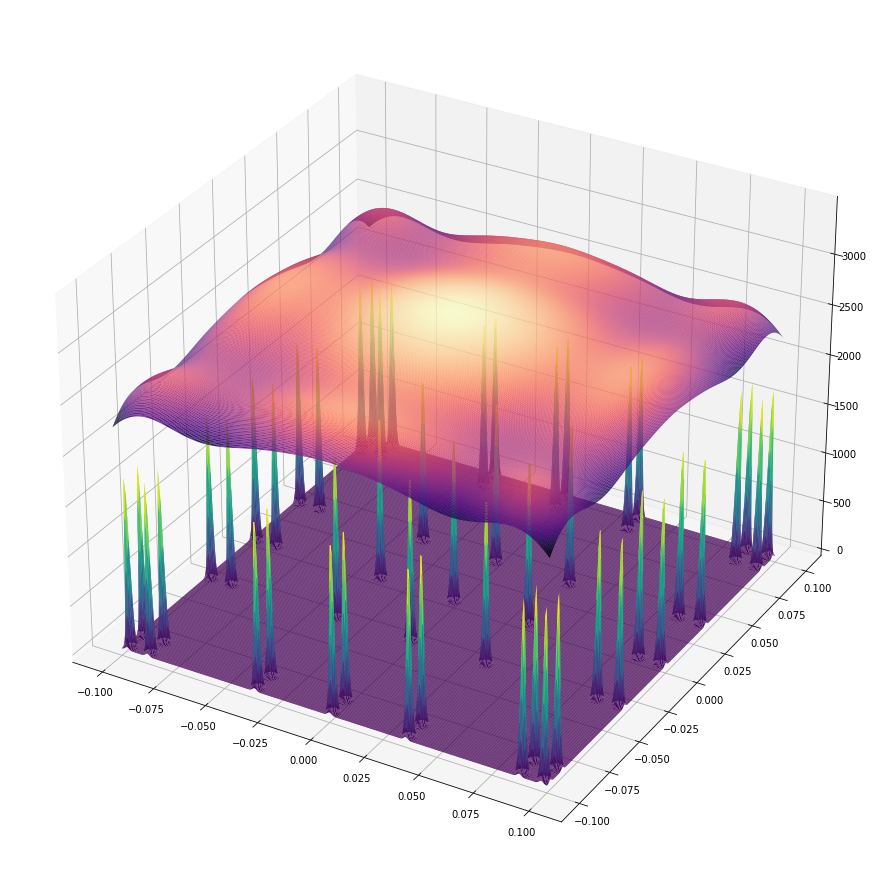

In [40]:
# 3D plot for square arrary
ds_Z = uilc.utils.lambertian_distribution(X, Y, ds_arr_s, s, H)
ds_led_distribution = uilc.utils.gauss_distribution(X,Y, ds_arr_s, nnls_sigma/10)
ds_led_distribution = ds_led_distribution *(ds_Z.max()/ds_led_distribution.max()) * 0.6
fig= plt.figure(figsize=(16,16))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, ds_Z, rstride= 1, cstride =1, cmap='magma', edgecolor='none')
ax.plot_surface(X,Y, ds_led_distribution, rstride = 1, cstride =1, cmap='viridis', edgecolor='none')
ax.set_zlim(0, ds_Z.max()*1.2)

In [41]:
fig.savefig('DA-ds-method.png', transparent=True)

### NNLS solve

Non-negative least square solve


In [13]:
nnls_n = 1000
threshold = 10
nnls_rho, nnls_position, nnls_F = uilc.disop.solve_system(s, W, H, 0, nnls_n, method="nnls")
nnls_lamb =  (napp+1) * nnls_rho.size / (W*nnls_rho.sum())
nnls_rho = nnls_lamb * nnls_rho


In [14]:
nnls_position = nnls_position[np.argwhere(nnls_rho>threshold)]
nnls_rho= nnls_rho[nnls_rho>threshold]

In [15]:
#fac = 0.7353 Boundary value is not apropriate for finding optimization of 2nd LED location from boundary
fac=0.75
delt_alzero = (1-fac) * nnls_rho[0] *0.3 #< threshold 
nnls_rho[0] *= fac
nnls_rho[nnls_rho.size-1] *= fac

#------------------------
#delt_alzero = 10
nnls_rho = np.insert(nnls_rho, 1, delt_alzero)
nnls_rho = np.insert(nnls_rho, nnls_rho.size-1, delt_alzero)

al = 1
be = 2
gam = al+be
d1 = (al*nnls_position[0] + be* nnls_position[1])/gam
k = nnls_position.size
d2 = (al*nnls_position[k-1] +  be* nnls_position[k-2])/gam


nnls_position = np.insert(nnls_position, 1, d1)
nnls_position = np.insert(nnls_position, nnls_position.size-1, d2)
#----------------------------------------------
nnls_k = math.sqrt(2)*0.95
nnls_sigma = W/(2*(napp+1)*nnls_k)

In [16]:
nnls_d = uilc.esc.coefficient(s, 4)
nnls_d * H
nnls_init0_esc_arr = uilc.utils.uniformarray(nnls_d*H, 4)
nnls_init0_bc_arr = uilc.disop.get_bc_expansion(nnls_init0_esc_arr, s, H, W, bc_xe, bc_xm)

In [17]:
nnls_init0_bc_arr = uilc.utils.uniformarray(W/8, 8)

In [18]:
ds_k = 0.01 
nnls_init0_bc_arr[0,1][0] = nnls_init0_bc_arr[0,1][0] - ds_k
nnls_init0_bc_arr[0,6][0] = nnls_init0_bc_arr[0,6][0] + ds_k

In [19]:
nnls_init0_bc_arr

array([[[-0.0875,  0.    ],
        [-0.0725,  0.    ],
        [-0.0375,  0.    ],
        [-0.0125,  0.    ],
        [ 0.0125,  0.    ],
        [ 0.0375,  0.    ],
        [ 0.0725,  0.    ],
        [ 0.0875,  0.    ]]])

In [20]:
nnls_arr = uilc.disop.nomarlization_lq(nnls_init0_bc_arr,  nnls_position, nnls_rho, napp+1, nnls_sigma, W)

In [21]:
nnls_arr

array([[[-0.10001003,  0.        ],
        [-0.09196571,  0.        ],
        [-0.05094702,  0.        ],
        [-0.01741514,  0.        ],
        [ 0.01741514,  0.        ],
        [ 0.05094702,  0.        ],
        [ 0.09196571,  0.        ],
        [ 0.10001003,  0.        ]]])

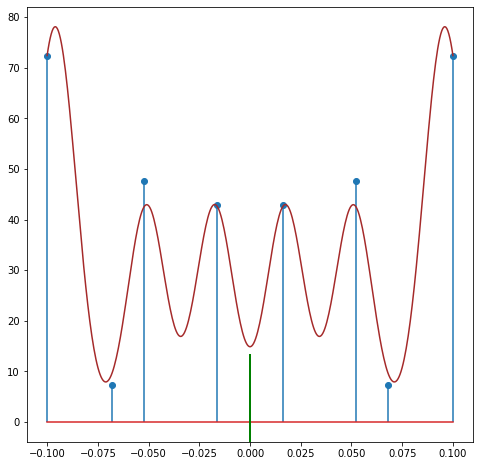

In [22]:
nnls_pos_xline = np.linspace(-W/2, W/2, 400)
nnls_pos_y = uilc.utils.gauss_distribution(nnls_pos_xline, np.array([[[0]]]), nnls_arr, nnls_sigma )

plt.figure(figsize=(8,8))
plt.stem(nnls_position, nnls_rho)
plt.plot(nnls_pos_xline, nnls_pos_y[0][0], color="brown")
for x in nnls_arr[0,0:napp][0:napp,0]/1000:
    plt.axvline(x, ymin=0, ymax=0.2 , color="green")    
plt.show()

In [23]:
nnls_arr

array([[[-0.10001003,  0.        ],
        [-0.09196571,  0.        ],
        [-0.05094702,  0.        ],
        [-0.01741514,  0.        ],
        [ 0.01741514,  0.        ],
        [ 0.05094702,  0.        ],
        [ 0.09196571,  0.        ],
        [ 0.10001003,  0.        ]]])

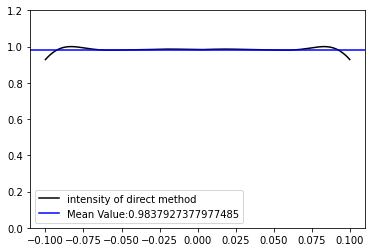

In [24]:
nnls_xline = np.linspace(-W/2, W/2 , 400)
nnls_intensity = uilc.utils.lambertian_distribution(ds_xline, np.array([[[0]]]), nnls_arr, s, H)
nnls_y = nnls_intensity[0][0]
nnls_y = nnls_y/nnls_y.max()
plt.plot(nnls_xline, nnls_y, label="intensity of direct method", color="black")
plt.axhline(y=nnls_y.mean(), color='b', label="Mean Value:{}".format(nnls_y.mean()))
plt.ylim(0, 1.2)
plt.legend()
plt.show()

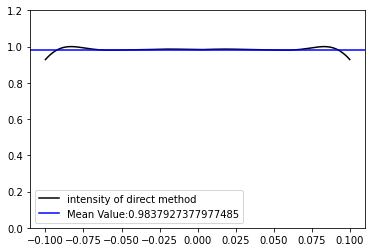

In [25]:
nnls_xline = np.linspace(-W/2, W/2 , 400)
nnls_intensity = uilc.utils.lambertian_distribution(nnls_xline, np.array([[[0]]]), nnls_arr, s, H)
nnls_y = nnls_intensity[0][0]
nnls_y = nnls_y/nnls_y.max()
plt.plot(nnls_xline, nnls_y, label="intensity of direct method", color="black")
plt.axhline(y=nnls_y.mean(), color='b', label="Mean Value:{}".format(nnls_y.mean()))
plt.ylim(0, 1.2)
plt.legend()
plt.show()

In [26]:
nnls_arr_s = uilc.utils.get_2d_array(nnls_arr, nnls_arr, dim=2)

(0.0, 4331.4635202279605)

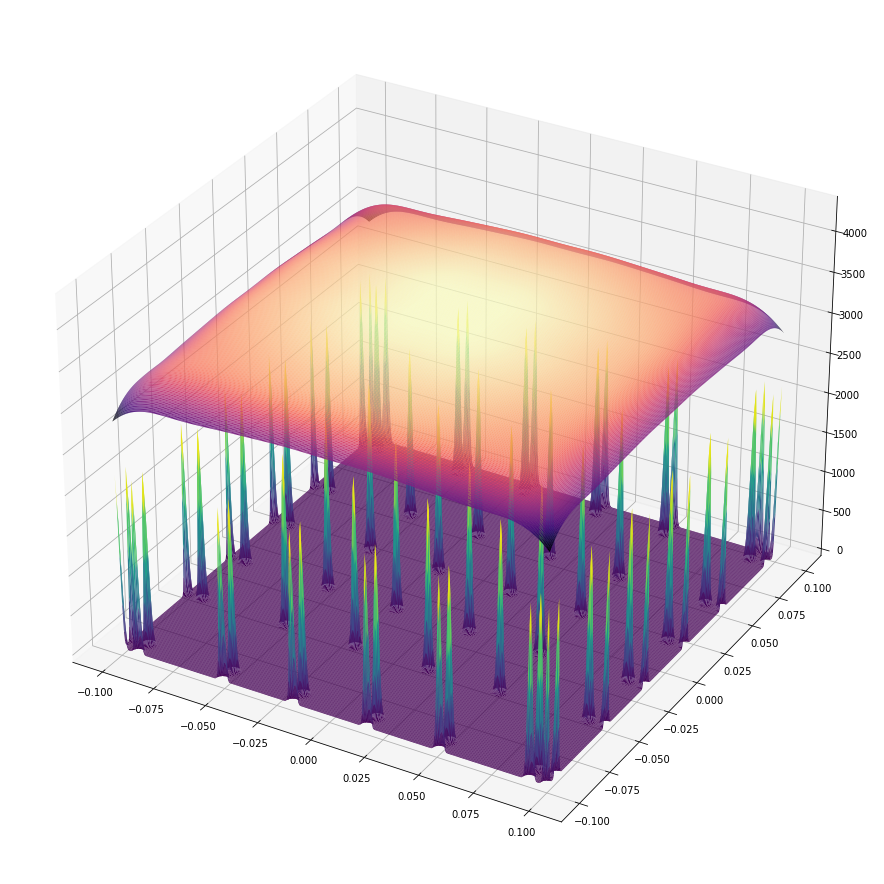

In [42]:
# 3D plot for square arrary
nnls_Z = uilc.utils.lambertian_distribution(X, Y, nnls_arr_s, s, H)
led_distribution = uilc.utils.gauss_distribution(X,Y, nnls_arr_s, nnls_sigma/10)
led_distribution = led_distribution *(nnls_Z.max()/led_distribution.max()) * 0.6

fig= plt.figure(figsize=(16,16))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, nnls_Z, rstride= 1, cstride =1, cmap='magma', edgecolor='none')
ax.plot_surface(X,Y, led_distribution, rstride = 1, cstride =1, cmap='viridis', edgecolor='none')
ax.set_zlim(0, nnls_Z.max()*1.2)

In [43]:
fig.savefig('DA-nnls-method.png', transparent=True)

## Compare

In [20]:
t_d = uilc.esc.coefficient(s, 8)* H
t_esc_arr = uilc.utils.uniformarray(t_d , 8)
esc_8_intensity = uilc.utils.lambertian_distribution(ds_xline, np.array([[[0]]]), t_esc_arr , s, H)
bc_8_intensity = uilc.utils.lambertian_distribution(ds_xline, np.array([[[0]]]), nnls_init0_bc_arr, s, H)

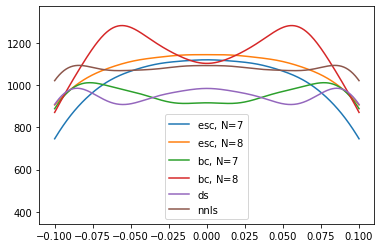

In [21]:
xline = np.linspace(-W/2, W/2 , 400)
plt.plot(xline, esc_intensity[0][0], label="esc, N=$7$")
plt.plot(xline, esc_8_intensity[0][0], label="esc, N=$8$")
plt.plot(xline, bc_intensity[0][0], label="bc, N=$7$")
plt.plot(xline, bc_8_intensity[0][0], label="bc, N=$8$")
plt.plot(xline, ds_intensity[0][0], label="ds")
plt.plot(xline, nnls_intensity[0][0], label="nnls")
vmin = esc_8_intensity[0][0].max()*0.3
vmax = esc_8_intensity[0][0].max()*1.2
plt.ylim(vmin, vmax)
plt.legend()
plt.show()

In [29]:
print((esc_8_intensity[0][0]).std()/(esc_8_intensity[0][0]).mean())
print((nnls_intensity[0][0]).std()/(nnls_intensity[0][0]).mean())

0.06008274034429879
0.011648876939145408


In [27]:
da_arr= np.array([[[-100.0225538 ,    0.        ],
                     [ -93.22522591,    0.        ],
                     [ -50.79115423,    0.        ],
                     [ -16.34009231,    0.        ],
                     [  16.34009231,    0.        ],
                     [  50.79115423,    0.        ],
                     [  93.22522591,    0.        ],
                     [ 100.0225538 ,    0.        ]]])/1000

In [28]:
xline = np.linspace(-(W/2), W/2, 600)

y_esc = uilc.utils.lambertian_distribution(xline, np.array([[[0]]]), esc_arr , s, H)[0][0]
y_bc =  uilc.utils.lambertian_distribution(xline, np.array([[[0]]]), bc_arr , s, H)[0][0]
y_da =  uilc.utils.lambertian_distribution(xline, np.array([[[0]]]), da_arr , s, H)[0][0]

y_esc = y_esc / y_esc.max()
y_bc = y_bc / y_bc.max()
y_da = y_da / y_da.max()

rmse_esc = y_esc.std()/y_esc.mean() 
rmse_bc  = y_bc.std()/y_bc.mean()
rmse_da  = y_da.std()/y_da.mean()

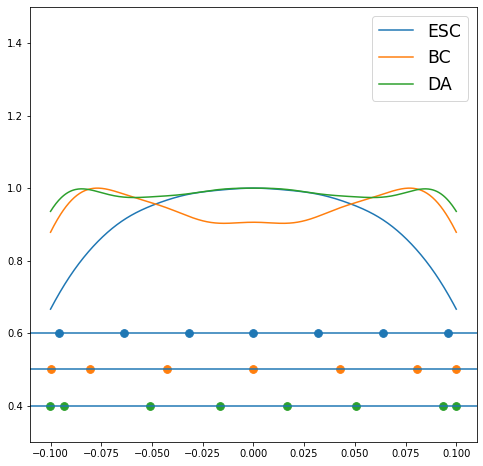

In [32]:
plt.figure(figsize=(8,8))
plt.plot(xline, y_esc, label="ESC")
plt.plot(xline, y_bc, label="BC")
plt.plot(xline, y_da, label="DA")

#ESC and BC================================

plt.scatter(uilc.utils.get_axis_list(esc_arr), 0.6*np.ones(7), s=60)
plt.scatter(uilc.utils.get_axis_list(bc_arr), 0.5*np.ones(7), s=60)
plt.scatter(uilc.utils.get_axis_list(da_arr), 0.4*np.ones(8), s=60)

plt.axhline(y = 0.6)
plt.axhline(y = 0.5)
plt.axhline(y = 0.4)


plt.rc('legend',fontsize='xx-large')
plt.ylim(0.3, 1.5)
plt.legend()
plt.show()

In [52]:
rmse_esc = esc_y.std() / esc_y.mean()
rmse_bc  = bc_y.std() / bc_y.mean()
rmse_da = nnls_y.std() / nnls_y.mean()

In [51]:
nnls_y.mean()

0.9837927377977485

In [62]:
def get_d(a):
    return (a.max() - a.min())/a.mean()

In [53]:
print(rmse_esc*100)
print(rmse_bc*100)
print(rmse_da*100)

10.11197256178725
3.780637937274113
1.060359682795018


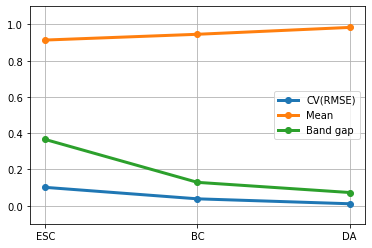

In [74]:
rmse_value = np.array([rmse_esc, rmse_bc,rmse_da])
mean_value = np.array([esc_y.mean(), bc_y.mean(), nnls_y.mean()])
d_value = np.array([get_d(esc_y), get_d(bc_y), get_d(nnls_y)])
x_value = np.array(['ESC', 'BC', 'DA'])

linewidth = 3
plt.plot(x_value, rmse_value, marker='o', linewidth=linewidth , label='CV(RMSE)')
plt.plot(x_value, mean_value, marker='o', linewidth=linewidth , label='Mean')
plt.plot(x_value, d_value, marker='o', linewidth=linewidth , label='Band gap')

plt.ylim(-0.1, 1.1)
plt.grid()
plt.legend()

plt.savefig('compare.png', transparent=True)